In [ ]:
import os
%env OPENAI_API_KEY=token
%env REPLICATE_API_TOKEN=token
%env ROS_MASTER_URI=http://localhost:11311
print(os.environ.get("OPENAI_API_KEY"))

[INFO] [1745804485.021577, 42.786000]: Waiting for joint trajectory action on /locobot/arm_controller/follow_joint_trajectory…
[INFO] [1745804485.053455, 42.789000]: Joint‐space action server ready
[INFO] [1745804487.239066407, 43.055000000]: Ready to take commands for planning group interbotix_arm.
[INFO] [1745804494.217926, 43.863000]: LocobotArmControl initialized


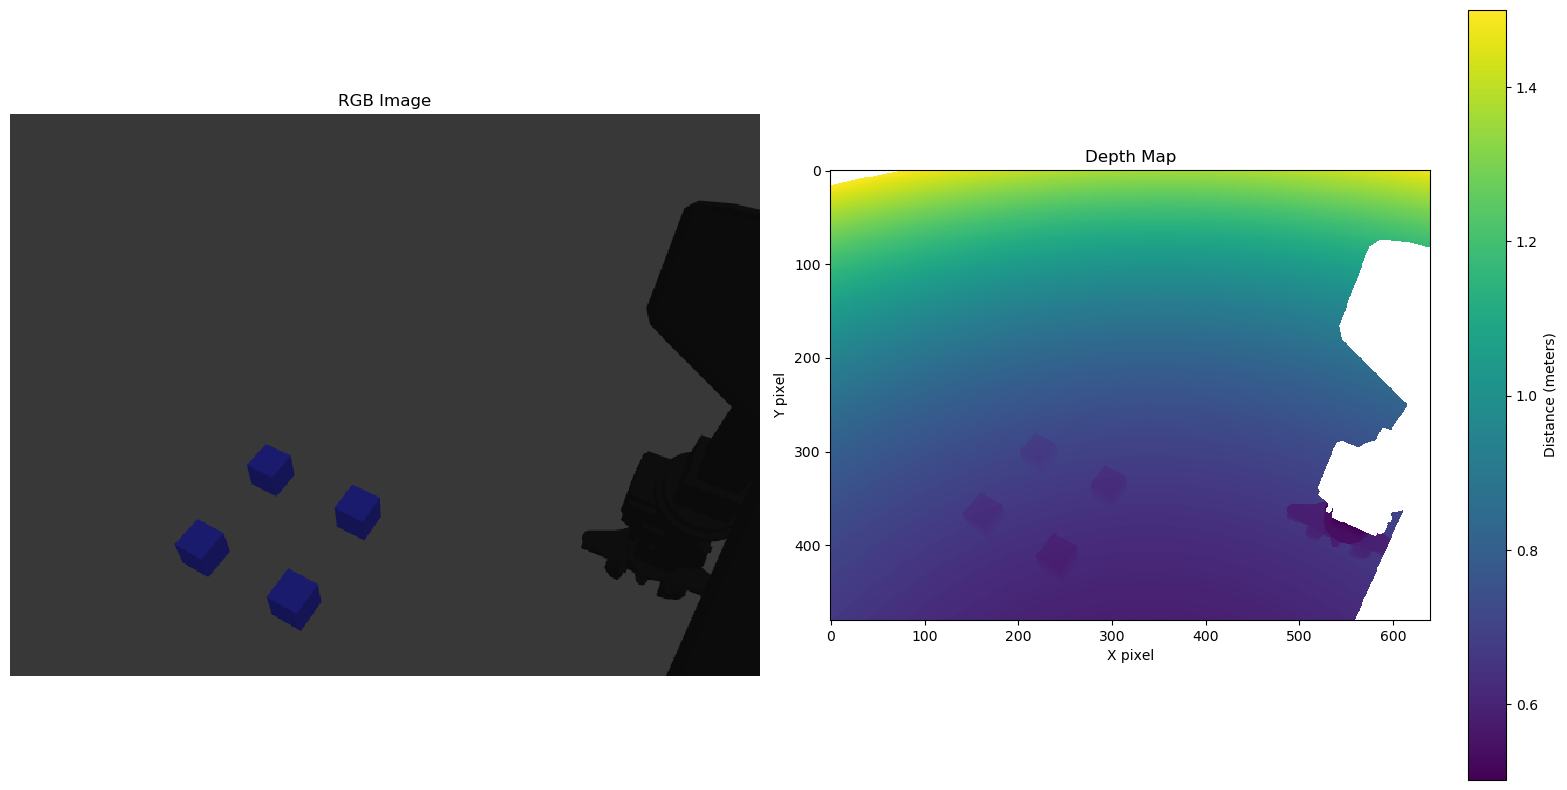

Using OpenAI API with model gpt-4o
Sending prompt to OpenAI...
Base response received.
To build the "L" shape from the first image, I'll deconstruct it into a buildable structure using the 10x10 coordinate grid. We'll need two blocks to create this structure.

### Deconstruction

1. **Vertical Part**: Place one block to form the vertical line of the "L".
   - Coordinates: (1, 3)

2. **Horizontal Part**: Place another block to form the horizontal line of the "L".
   - Coordinates: (2, 2)

### Current Environment

Let's assume the initial positions of the blocks in the second image are:

- Bottom left block: (0, 0)
- Bottom right block: (1, 0)
- Top left block: (0, 1)
- Top right block: (1, 1)

### Steps

- **Action 1**:
  - `{ pos_init: {x: 0, y: 0}, pos_finale: {x: 1, y: 3}, notice: "Pick the bottom left block and place it vertically for the L shape." }`

- **Action 2**:
  - `{ pos_init: {x: 1, y: 0}, pos_finale: {x: 2, y: 2}, notice: "Pick the bottom right block and place it horizonta

KeyboardInterrupt: 

In [4]:
#source devel/setup.bash
#roslaunch locobot_connector cube_spawner.launch num_cubes:=4 positions:=[[0.30,0.25,0.01],[0.30,0.35,0.01],[0.4,0.25,0.01],[0.4,0.35,0.01]]
import numpy as np
import matplotlib.pyplot as plt
from visioncraft.locobot.camera import LocobotCamera
from visioncraft.locobot.arm_control import LocobotArmControl
import rospy
from visioncraft.vlm.vlm_pipeline import VLMPipeline
import os

placing_grid = [
    [[0.1, -0.1, 0.01], [0.1, -0.15, 0.01], [0.1, -0.2, 0.01], [0.1, -0.25, 0.01], [0.1, -0.3, 0.01], [0.1, -0.35, 0.01], [0.1, -0.4, 0.01], [0.1, -0.45, 0.01], [0.1, -0.5, 0.01], [0.1, -0.55, 0.01]],
    [[0.15, -0.1, 0.01], [0.15, -0.15, 0.01], [0.15, -0.2, 0.01], [0.15, -0.25, 0.01], [0.15, -0.3, 0.01], [0.15, -0.35, 0.01], [0.15, -0.4, 0.01], [0.15, -0.45, 0.01], [0.15, -0.5, 0.01], [0.15, -0.55, 0.01]],
    [[0.2, -0.1, 0.01], [0.2, -0.15, 0.01], [0.2, -0.2, 0.01], [0.2, -0.25, 0.01], [0.2, -0.3, 0.01], [0.2, -0.35, 0.01], [0.2, -0.4, 0.01], [0.2, -0.45, 0.01], [0.2, -0.5, 0.01], [0.2, -0.55, 0.01]],
    [[0.25, -0.1, 0.01], [0.25, -0.15, 0.01], [0.25, -0.2, 0.01], [0.25, -0.25, 0.01], [0.25, -0.3, 0.01], [0.25, -0.35, 0.01], [0.25, -0.4, 0.01], [0.25, -0.45, 0.01], [0.25, -0.5, 0.01], [0.25, -0.55, 0.01]],
    [[0.3, -0.1, 0.01], [0.3, -0.15, 0.01], [0.3, -0.2, 0.01], [0.3, -0.25, 0.01], [0.3, -0.3, 0.01], [0.3, -0.35, 0.01], [0.3, -0.4, 0.01], [0.3, -0.45, 0.01], [0.3, -0.5, 0.01], [0.3, -0.55, 0.01]],
    [[0.35, -0.1, 0.01], [0.35, -0.15, 0.01], [0.35, -0.2, 0.01], [0.35, -0.25, 0.01], [0.35, -0.3, 0.01], [0.35, -0.35, 0.01], [0.35, -0.4, 0.01], [0.35, -0.45, 0.01], [0.35, -0.5, 0.01], [0.35, -0.55, 0.01]],
    [[0.4, -0.1, 0.01], [0.4, -0.15, 0.01], [0.4, -0.2, 0.01], [0.4, -0.25, 0.01], [0.4, -0.3, 0.01], [0.4, -0.35, 0.01], [0.4, -0.4, 0.01], [0.4, -0.45, 0.01], [0.4, -0.5, 0.01], [0.4, -0.55, 0.01]],
    [[0.45, -0.1, 0.01], [0.45, -0.15, 0.01], [0.45, -0.2, 0.01], [0.45, -0.25, 0.01], [0.45, -0.3, 0.01], [0.45, -0.35, 0.01], [0.45, -0.4, 0.01], [0.45, -0.45, 0.01], [0.45, -0.5, 0.01], [0.45, -0.55, 0.01]],
    [[0.5, -0.1, 0.01], [0.5, -0.15, 0.01], [0.5, -0.2, 0.01], [0.5, -0.25, 0.01], [0.5, -0.3, 0.01], [0.5, -0.35, 0.01], [0.5, -0.4, 0.01], [0.5, -0.45, 0.01], [0.5, -0.5, 0.01], [0.5, -0.55, 0.01]],
    [[0.55, -0.1, 0.01], [0.55, -0.15, 0.01], [0.55, -0.2, 0.01], [0.55, -0.25, 0.01], [0.55, -0.3, 0.01], [0.55, -0.35, 0.01], [0.55, -0.4, 0.01], [0.55, -0.45, 0.01], [0.55, -0.5, 0.01], [0.55, -0.55, 0.01]]
]


def visualize_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Create a depth map visualization and show the RGB image using matplotlib
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    # Create visualization
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot RGB image
    axs[0].imshow(img)
    axs[0].set_title('RGB Image')
    axs[0].axis('off')
    

    # Plot depth map
    depth_plot = axs[1].imshow(depth_map, cmap='viridis')
    axs[1].set_title('Depth Map')
    axs[1].set_xlabel('X pixel')
    axs[1].set_ylabel('Y pixel')
    fig.colorbar(depth_plot, ax=axs[1], label='Distance (meters)')
    
    plt.tight_layout()
    plt.show()

def get_depth_map(cam, min_distance=0.5, max_distance=1.5):
    """
    Get the depth map from the camera
    """
    # Get the image
    img = cam.get_image()
    if img is None:
        print("No image received")
        return
        
    height, width = img.shape[:2]
    
    # Create depth map
    depth_map = np.full((height, width), np.nan)
    
    # Fill depth map with distances
    for y in range(height):
        for x in range(width):
            point = cam.get_point_at_pixel(x, y)
            if point is not None:
                # Calculate distance from camera (Euclidean distance)
                distance = np.sqrt(point[0]**2 + point[1]**2 + point[2]**2)
                if min_distance <= distance <= max_distance:
                    depth_map[y, x] = distance  # Only keep valid distances
    
    return depth_map, height, width

def pick_block_action(action, cam, arm_control):
    print(f"Pick block Action: {action}")
    pos_init = action['pos_init']
    depth_map, height, width = get_depth_map(cam)
    x = int(pos_init["x"]/100 * width)
    y = int(pos_init["y"]/100 * height)
    go_to_pos(cam, arm_control, x, y)
    print(f"X: {x}, Y: {y}")
    if depth_map[y, x] is not None:
        print(f"Distance: {depth_map[y, x]} m")
    else:
        print("No valid distance found at this pixel.")

def go_to_pos(cam,arm_control, x, y):

    img = cam.get_image()

    point_camera = cam.get_point_at_pixel(x, y)
    point_base = cam.get_target_coordinate_from_camera(point_camera)
    
    print("pick point_base : ", point_base)
    arm_control.pick(point_base)

def place_block_action(action, cam, arm_control):
    print(f"Place block Action: {action}")
    pos_finale = action['pos_finale']
    x = int(pos_finale["x"])
    y = int(pos_finale["y"])
    arm_control.place(placing_grid[x][y])

def main():
    cam = LocobotCamera()
    arm_control = LocobotArmControl()

    cam.pan(0.5)
    cam.tilt(0.8)
    img = cam.get_image()
        
    # Visualize depth map and image
    visualize_depth_map(cam)
    plt.imsave('../resources/rgb_image.png', img)

    vlm_pipeline = VLMPipeline(model_name="gpt-4o", openai_api_key=os.environ.get("OPENAI_API_KEY"))
    vlm_pipeline.set_current_image("../resources/rgb_image.png")
    vlm_pipeline.set_goal_image("../resources/Ldraw.png")
    json_answer = vlm_pipeline.run_pipeline()
    for actions in json_answer:
            for action in json_answer[actions]:
                # Each action to accomplish
                pick_block_action(action, cam, arm_control)
                place_block_action(action, cam, arm_control)

    # Wait for some data to be received
    rospy.sleep(1.0)


if __name__ == '__main__':
    main()


# LaTTe

In [1]:
!pip install ftfy regex tqdm dqrobotics rospkg similaritymeasures Cython transformers scikit-learn opencv-python
!pip install git+https://github.com/openai/CLIP.git

     |████████████████████████████████| 43 kB 590 kB/s eta 0:00:01
     |████████████████████████████████| 785 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 445 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 401 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 10.0 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.1 MB 3.2 MB/s eta 0:00:01    |████▏                           | 1.4 MB 1.8 MB/s eta 0:00:06
     |████████████████████████████████| 63.0 MB 18 kB/s  eta 0:00:01    |▋                               | 1.1 MB 3.5 MB/s eta 0:00:18     |█████████████████████           | 41.5 MB 2.5 MB/s eta 0:00:09     |█████████████████████████▉      | 50.9 MB 3.5 MB/s eta 0:00:04
     |████████████████████████████████| 471 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 3.0 MB/s eta 0:00:01
     |████████████████████████████████| 481 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 2.6

```
git clone git@github.com:Simnol22/latte.git
```

Download models (need to cd in ros_ws/latte first)
```
pip install gdown
gdown --folder https://drive.google.com/drive/folders/1HQNwHlQUOPMnbPE-3wKpIb6GMBz5eqDg?usp=sharing -O models/.
```
Download synthetic dataset  
```
gdown --folder https://drive.google.com/drive/folders/1_bhWWa9upUWwUs7ln8jaWG_bYxtxuOCt?usp=sharing -O data/.
```
unzip image dataset
```
unzip image_dataset.zip
```


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Button, TextBox
# for CPU only
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

#print current working directory
import sys
import os
print("Current working directory:", os.getcwd())
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the GPU ID you want to use

import numpy as np

from latte.src.motion_refiner_4D import Motion_refiner, MAX_NUM_OBJS
from latte.src.config import *
from latte.src.userstudy_interface import *


traj_n = 40
mr = Motion_refiner(load_models=True ,traj_n = traj_n, locality_factor=True, clip_only=False,load_precomp_emb=True)
feature_indices, obj_sim_indices, obj_poses_indices, traj_indices = mr.get_indices()
embedding_indices = np.concatenate([feature_indices,obj_sim_indices, obj_poses_indices])

from latte.src.TF4D_mult_features import *

model_name = "TF-num_layers_enc:1-num_layers_dec:5-d_model:400-dff:512-num_heads:8-dropout_rate:0.1-wp_d:4-num_emb_vec:4-bs:16-dense_n:512-num_dense:3-concat_emb:True-features_n:793-optimizer:adam-norm_layer:True-activation:tanh.h5"
model_file = models_folder+model_name
model = load_model(model_file, delimiter="-")



def scale_to_range(points, current_min, current_max, min_val=-0.3, max_val=0.3):
 
    # Handle case where all values are the same
    if current_max == current_min:
        return points.copy()  # or scale differently
        
    scaled = points.copy()
    scaled[:, :3] = min_val + (points[:, :3] - current_min) * (max_val - min_val) / (current_max - current_min)
    return scaled


def rescale_to_original(scaled_points, original_min, original_max, scaled_min=-0.3, scaled_max=0.3):
    """Rescale from [-0.3, 0.3] back to [0, 39]."""
    rescaled = scaled_points.copy()
    rescaled[:, :3] = original_min + (scaled_points[:, :3] - scaled_min) * (original_max - original_min) / (scaled_max - scaled_min)
    return rescaled

# ===========================================
# 2. Define a dummy trajectory (same format as in User_study_interface)
# ===========================================
def create_trajectory(input_traj):
    return {
        "input_traj":input_traj,
        "output_traj": None,  # Will be filled by model
        "obj_poses": [
            [0.1, 0.1, 0.3]    # Object 2
        ],
        "obj_names": ["object"],
        "text": "Initial trajectory",
        "locality_factor": 0.5,
        "image_paths": None
    }

# ===========================================
# 3. Modify trajectory using your model & MR (same as User_study_interface)
# ===========================================
def modify_trajectory(data, instruction, model, mr):
    """Modify trajectory using mr.apply_interaction() (same as in User_study_interface)"""
    pred, _ = mr.apply_interaction(
        model,
        data,
        instruction,
        label=False,
        images=None
    )
    data["output_traj"] = pred[0].tolist()  # Store modified trajectory
    print("Modified trajectory:", data["output_traj"])
    return data

# ===========================================
# 4. Visualization (3D plot with trajectory and objects)
# ===========================================
def plot_trajectories(data, ax):
    ax.clear()
    
    # Plot objects
    for pos, name in zip(data["obj_poses"], data["obj_names"]):
        ax.scatter(*pos, s=100, color='red', alpha=0.7)
        ax.text(*pos, name, color='black', fontsize=10)
    
    # Original trajectory (red)
    orig_traj = np.array(data["input_traj"])
    ax.plot(orig_traj[:, 0], orig_traj[:, 1], orig_traj[:, 2], 
            'r-', label="Original", linewidth=2, alpha=0.7)
    
    # Modified trajectory (blue) if available
    if data["output_traj"] is not None:
        mod_traj = np.array(data["output_traj"])
        ax.plot(mod_traj[:, 0], mod_traj[:, 1], mod_traj[:, 2], 
                'b-', label="Modified", linewidth=2, alpha=0.7)
    
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title("Trajectory Modification", fontsize=14)
    set_axes_equal(ax)  # Ensures 3D aspect ratio is correct

def set_axes_equal(ax):
    """Ensure 3D plot has equal scaling."""
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    origin = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:, 1] - limits[:, 0]))
    ax.set_xlim3d([origin[0] - radius, origin[0] + radius])
    ax.set_ylim3d([origin[1] - radius, origin[1] + radius])
    ax.set_zlim3d([origin[2] - radius, origin[2] + radius])

# ===========================================
# 5. Interactive GUI (TextBox + Button)
# ===========================================
class InteractiveTrajectoryEditor:
    def __init__(self, model, mr, input_traj):
        self.model = model
        self.mr = mr
        self.data = create_trajectory(input_traj)
        
        # Set up figure
        self.fig = plt.figure(figsize=(10, 8))
        self.ax = self.fig.add_subplot(111, projection='3d')
        
        # Instruction text box
        self.ax_text = plt.axes([0.2, 0.05, 0.6, 0.05])
        self.text_box = TextBox(self.ax_text, 'Instruction:', initial="Avoid the first object")
        
        # Modify button
        self.ax_button = plt.axes([0.2, 0.01, 0.2, 0.04])
        self.button = Button(self.ax_button, 'Modify Trajectory')
        self.button.on_clicked(self.on_modify)
        
        # Initial plot
        plot_trajectories(self.data, self.ax)
        plt.tight_layout()
    
    def on_modify(self, event):
        """Apply modification when button is clicked."""
        instruction = self.text_box.text
        self.data = modify_trajectory(self.data, instruction, self.model, self.mr)
        self.data["output_traj"] = rescale_to_original(np.array(self.data["output_traj"]), current_min, current_max) 
        print("Modified trajectory:", self.data["output_traj"])
        plot_trajectories(self.data, self.ax)
        self.fig.canvas.draw_idle()  # Update plot

input_traj = np.array([
    [0, 0, 0, 0.2],  # Point 1
    [1, 1, 1, 0.2],  # Point 2
    [2, 2, 2, 0.2],  # Point 3
    [3, 3, 3, 0.2],  # Point 4
    [4, 4, 4, 0.2],  # Point 5
    [5, 5, 5, 0.2],  # Point 6
    [6, 6, 6, 0.2],  # Point 7
    [7, 7, 7, 0.2],  # Point 8
    [8, 8, 8, 0.2],  # Point 9
    [9, 9, 9, 0.2],  # Point 10
    [10, 10, 10, 0.2],  # Point 11
    [11, 11, 11, 0.2],  # Point 12
    [12, 12, 12, 0.2],  # Point 13
    [13, 13, 13, 0.2],  # Point 14
    [14, 14, 14, 0.2],  # Point 15
    [15, 15, 15, 0.2],  # Point 16
    [16, 16, 16, 0.2],  # Point 17
    [17, 17, 17, 0.2],  # Point 18
    [18, 18, 18, 0.2],  # Point 19
    [19, 19, 19, 0.2],  # Point 20
    [20, 20, 20, 0.2],  # Point 21
    [21, 21, 21, 0.2],  # Point 22
    [22, 22, 22, 0.2],  # Point 23
    [23, 23, 23, 0.2],  # Point 24
    [24, 24, 24, 0.2],  # Point 25
    [25, 25, 25, 0.2],  # Point 26
    [26, 26, 26, 0.2],  # Point 27
    [27, 27, 27, 0.2],  # Point 28
    [28, 28, 28, 0.2],  # Point 29
    [29, 29, 29, 0.2],  # Point 30
    [30, 30, 30, 0.2],  # Point 31
    [31, 31, 31, 0.2],  # Point 32
    [32, 32, 32, 0.2],  # Point 33
    [33, 33, 33, 0.2],  # Point 34
    [34, 34, 34, 0.2],  # Point 35
    [35, 35, 35, 0.2],  # Point 36
    [36, 36, 36, 0.2],  # Point 37
    [37, 37, 37, 0.2],  # Point 38
    [38, 38, 38, 0.2],  # Point 39
    [39, 39, 39, 0.2]   # Point 40
], dtype=np.float64)  

current_min = np.min(input_traj[:, :3])
current_max = np.max(input_traj[:, :3])

scaled_input = scale_to_range(input_traj, current_min, current_max)

data = create_trajectory(scaled_input)
instructions = "Go higher than original trajectory"
data = modify_trajectory(data, instructions, model, mr)
data["output_traj"] = rescale_to_original(np.array(data["output_traj"]), current_min, current_max)
print("Modified trajectory:", data["output_traj"])

Current working directory: /home/vscode/ros_ws/notebooks
loading BERT model... done
loading CLIP model... done
loading precomputed CLIP text embbedings... done
loading precomputed CLIP img embbedings... 

KeyboardInterrupt: 